In [369]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import requests
from io import StringIO
from plotly import __version__
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import datetime
import scipy.stats as stats



%matplotlib inline

In [331]:
def get_recalls_by_champion(champion):
    """
    """
    all_purchases = []

    for game_dump in os.listdir('./game_dumps'):
        df = pd.DataFrame()
        try:
            with open('./game_dumps/'+ game_dump,'r') as f:
                data = json.load(f)
            temp = pd.DataFrame(data['timeline']['frames'])
            participants = data['participants']

            champion_in_game = False
            for participant in participants:
                if participant['championId'] == champion:
                    champion_in_game= True
                    break
            
            if not champion_in_game:
                continue
            
        except:
            continue
    

        df = df.append(temp)

    #   Items purchased
        item_purchase_events = []
        for index, row in df['events'].iteritems():
            for event in row:
                if event['type'] == "ITEM_PURCHASED" and event['timestamp'] > 180000:
                    item_purchase_events.append(event)

    #   Champions Killed
        champion_kills = []
        for index, row in df['events'].iteritems():
            for event in row:
                if event['type'] == "CHAMPION_KILL":
                    champion_kills.append(event)


        recall_buys = []
    #   Remove items purchased after deaths
        for purchase in item_purchase_events:
            purchased_after_kill = False

            for kill in champion_kills:
                if purchase['timestamp'] < 30000 + kill['timestamp'] and purchase['timestamp'] > kill['timestamp'] - 30000:
                    if kill['victimId'] == purchase['participantId']:
                        purchased_after_kill = True
                        break
            if purchased_after_kill:
                continue
            else:
                recall_buys.append(purchase)

    #   Subest of all first buys
        players_with_first_buys = set()
        first_purchases = []
#         print(recall_buys)
#         for purchase in recall_buys:
#             if purchase['participantId'] in players_with_first_buys:
#                 continue
#             else:
#                 players_with_first_buys.add(purchase['participantId'])
#                 first_purchases.append(purchase)
        first_purchases.append(recall_buys[0])

#         if len(first_purchases) <10:
#             continue
        purchase_times = [time['timestamp'] for time in first_purchases if time['timestamp'] < 600000]
        all_purchases.extend(purchase_times)
    return all_purchases
        

In [332]:
def get_player_recall_history(player_id, champion_id,region):
    API_URL = '.api.riotgames.com/lol/'
    API_KEY = '?api_key=RGAPI-3a4ed2fd-dc8d-4bcc-acd5-360c10f25360'
    MATCH_ID_ENDPOINT = 'match/v3/matchlists/by-account/'
    GAME_TIMELINE_ENDPOINT = 'match/v3/timelines/by-match/'
    MATCH_INFORMATION_ENDPOINT = 'match/v3/matches/'

    
    r = requests.get('https://'+region+API_URL+MATCH_ID_ENDPOINT+player_id+API_KEY)
    matches = r.json()
        
    match_list = [match['gameId'] for match in matches['matches'] if match['champion'] == champion_id]
    
    match_timelines = {}
    for match in match_list:
        r = requests.get('https://'+region+API_URL+GAME_TIMELINE_ENDPOINT+str(match)+API_KEY)
        match_timelines[match]= r.json()
        
        
        # Query the participant ID from a new request, and ad it to the match_timelines dict
        pid_request = requests.get('https://'+region+API_URL+MATCH_INFORMATION_ENDPOINT+str(match)+API_KEY)
        pid_json = pid_request.json()
        
        # Find the participant ID and add it as a key to our megadict
        for participant in pid_json['participants']:
            if participant['championId'] == champion_id:    
                match_timelines[match]['participantId'] = participant['participantId']
        
    return match_timelines

In [333]:
def get_recall_timestamps_for_player(match_timelines):
    """
    Args:
        Object of games and their timelines
    Returns:
        list of times in milliseconds
    """    
    
    for match in match_timelines:
        participantId = match_timelines[match]['participantId']
        #   Items purchased
        item_purchase_events = []
        for frame in match_timelines[match]['frames']:
            
            for event in frame['events']:
                
            
                if event['type'] == 'ITEM_PURCHASED' and event['timestamp'] > 180000:
                    item_purchase_events.append(event)                       
                
                
        # Filter items purchased to only those made by the participant
        player_buys = []      
        for purchase in item_purchase_events:
            if purchase['participantId'] == participantId:
                player_buys.append(purchase)
                
                
                

        #   Champions Killed
        champion_kills = []
        for frame in match_timelines[match]['frames']:
            
            for event in frame['events']:
                if event['type'] == 'CHAMPION_KILL':
                    champion_kills.append(event)
                
                
#                   if purchase['participantId']!= participantId:
# #                     print(purchase['timestamp']['victimId'], participantId)           
                
        
        #  Ignore purchases after death  
        recall_buys = []
        purchased_after_kill = False
        for purchase in player_buys:
            for kill in champion_kills:
                if kill['victimId'] == participantId:
                    if purchase['timestamp'] < 30000 + kill['timestamp'] and purchase['timestamp'] > kill['timestamp'] - 30000:
                        purchased_after_kill = True
                        break
            if purchased_after_kill:
                continue
            else:
                recall_buys.append(purchase)
                
    return [buy['timestamp'] for buy in recall_buys]

In [296]:
aatrox_player_match_history = get_player_recall_history(player_id='219693852', champion_id = 266, region= 'euw1')

In [351]:
aatrox_player_recall_times = get_recall_timestamps_for_player(aatrox_player_match_history)

In [347]:
purchase_times_thresh = get_recalls_by_champion(412)
purchase_times_aatrox = get_recalls_by_champion(266)

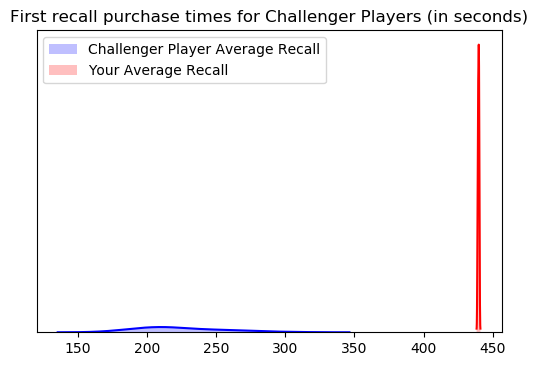

In [383]:
fig = plt.figure(dpi=100)
plt.yticks([])
plt.title('First recall purchase times for Challenger Players (in seconds)')
ax = sns.kdeplot([purchase/1000 for purchase in purchase_times_thresh],color='blue', shade=True)
ax2 = sns.kdeplot([purchase/1000 for purchase in aatrox_player_recall_times],color='red', shade=True)

plt.legend(('Challenger Player Average Recall','Your Average Recall'))



# imgdata = StringIO()
# fig.savefig(imgdata, format='svg')
# imgdata.seek(0)  # rewind the data

# svg_dta = imgdata.buf  # this is svg data

# file('test.htm', 'w').write(svg_dta)  # test it


plt.savefig("First-recall-purchase-for-player-single-match.svg")
os.rename('First-recall-purchase-for-player-single-match.svg','svg.txt')
with open('svg.txt','r') as f:
    svg = f.read()



[439174, 439702, 440103, 439174, 439702, 440103]